# Figure 5: Skipped intronic site analysis

**Description:** Genomic context model development for intron sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import genomic_context

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import test_proportions_2indep


## IMPORT DATA

In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"

DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_05")
os.makedirs(OUTDIR, exist_ok = True)

ENCODE_DIR = os.path.join(PROJECT, "model", "rna_validation", "encode_project")


## Data loading and preparation

In [6]:
is_data = pd.read_csv(os.path.join(RESDIR, '20220121-215928.denom.all.intron_skipped.transformed.txt'), sep = "\t")
print(is_data.shape)

is_features = [
    'intron_pos_3', 
    'up_exon_v2_log10', 
    'down_exon_log10', 
    'distance_upstream5ss_log10', 
    'score_first_upstream3ss', 
    'score_downstream3ss',
    'predicted_logit', 
    'ratio_3ss_to_3ss'
]

is_data['distance_upstream5ss'] = 10 ** is_data['distance_upstream5ss_log10']
is_data['distance_first_upstream3ss'] = 10 ** is_data['distance_first_upstream3ss_log10']
is_data['feature_size'] = 10 ** is_data['feature_size_log10']
is_data['distance_downstream3ss'] = is_data['feature_size'] - is_data['distance_upstream5ss']

is_data['position_upstream5ss']   = is_data.apply(lambda row: (row['start'] - row['distance_upstream5ss']) if (row['strand'] == '+') else (row['start'] + row['distance_upstream5ss']), axis = 1)
is_data['position_downstream3ss'] = is_data.apply(lambda row: (row['start'] + row['distance_downstream3ss']) if (row['strand'] == '+') else (row['start'] - row['distance_downstream3ss']), axis = 1)

is_data['ratio_3ss_to_3ss'] = np.log2((is_data['distance_downstream3ss'] + 100) / (is_data['distance_first_upstream3ss'] + 100))


(167013, 45)


#### Identify positive sites

In [7]:
is_pos = is_data.loc[is_data['cluster_reads_slop'] > 0].copy()

is_site_dict = {}

for i,row in is_pos.iterrows():
    is_site_dict[(row['chrom'], row['start'], row['strand'], row['gene'])] = row['cluster_reads_slop']


In [8]:
is_positives = is_data.loc[is_data['cluster_reads_slop'] >= 100].copy()
is_negatives = is_data.loc[is_data['cluster_reads_slop'] == 0].copy()

print("POSITIVES:", is_positives.shape)
print("NEGATIVES:", is_negatives.shape)


POSITIVES: (2594, 52)
NEGATIVES: (155370, 52)


#### Sample negative sites from introns with no used polyA sites

In [11]:
is_negatives_samp = is_negatives.sample(n = 30000, replace = False, random_state = 1234)
is_negatives_samp['nc_eligible'] = is_negatives_samp.apply(genomic_context.check_sites_in_intron, args = (is_pos, is_site_dict), axis = 1)
print("ELIGIBLE NCs:", is_negatives_samp.nc_eligible.sum())


ELIGIBLE NCs: 5366


In [12]:
is_negatives_maxpergene = genomic_context.downsample_sites_per_gene(is_negatives_samp.loc[is_negatives_samp['nc_eligible'] == True], 
                                                                    is_positives['gene'].value_counts().max())
print("DOWNSAMPLED NCs:", is_negatives_maxpergene.shape)


DOWNSAMPLED NCs: (3736, 53)


#### Partition data into training/testing splits

In [167]:
random_state = 2774937218

is_positives = is_data.loc[is_data['cluster_reads_slop'] >= 100].copy()
is_positives['split'] = 'train'
is_positives.loc[is_positives.sample(frac = 0.1, replace = False, random_state = random_state).index, 'split'] = 'test'

is_negatives = is_negatives_maxpergene.loc[is_negatives_maxpergene['nc_eligible'] == 1].copy().sample(n = len(is_positives), replace = False, random_state = random_state)
is_negatives['split'] = 'train'
is_negatives.loc[is_negatives.sample(frac = 0.1, replace = False, random_state = random_state).index, 'split'] = 'test'

new_is_data = pd.concat([is_positives, is_negatives], sort = False, ignore_index = True)
print("\nBINARY CLASS:\n", new_is_data.score_binary.value_counts())
print("\nSPLIT:\n", new_is_data.split.value_counts())

with open(os.path.join(RESDIR, 'is_data.pickle'), mode = 'wb') as handle:
    pickle.dump(new_is_data, handle)



BINARY CLASS:
 1    2594
0    2594
Name: score_binary, dtype: int64

SPLIT:
 train    4670
test      518
Name: split, dtype: int64


#### Scale data to normalize mean and standard deviation

In [168]:
scaler_is = StandardScaler().fit(new_is_data.loc[new_is_data['split'] == 'train', is_features[1:]])

# with open(os.path.join(RESDIR, 'is_scaler_ratio.pickle'), mode = 'wb') as handle:
#     pickle.dump(scaler_is, handle)

Xall_scaled = pd.DataFrame(scaler_is.transform(new_is_data[is_features[1:]]), index = new_is_data.index, columns = new_is_data[is_features[1:]].columns)
Xall_scaled[is_features[0]] = new_is_data[is_features[0]]
Yall_c = new_is_data['score_binary']

Xtr_scaled = Xall_scaled.loc[new_is_data['split'] == 'train'].copy()
Ytr_c = new_is_data.loc[new_is_data['split'] == 'train', 'score_binary'].copy()

Xte_scaled = Xall_scaled.loc[new_is_data['split'] == 'test'].copy()
Yte_c = new_is_data.loc[new_is_data['split'] == 'test', 'score_binary'].copy()

is_all_data = {
    'train' : {
        'X' : Xtr_scaled,
        'Y' : Ytr_c,
    },
    'test' : {
        'X' : Xte_scaled,
        'Y' : Yte_c,
    }
}


#### Fit logistic regression model

In [169]:
is_model = sm.Logit(Ytr_c, Xtr_scaled[is_features]).fit()
print(is_model.summary())

# with open(os.path.join(RESDIR, 'is_model_ratio.pickle'), mode = 'wb') as handle:
#     pickle.dump(is_model, handle)


Optimization terminated successfully.
         Current function value: 0.381680
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           score_binary   No. Observations:                 4670
Model:                          Logit   Df Residuals:                     4662
Method:                           MLE   Df Model:                            7
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                  0.4494
Time:                        01:16:49   Log-Likelihood:                -1782.4
converged:                       True   LL-Null:                       -3237.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intron_pos_3                   1.4245      0.126     11.346      0.000      

In [142]:
is_all_data['train']['Ypred'] = {}
is_all_data['test']['Ypred']  = {}
    
new_preds = is_model.predict(is_all_data['train']['X'][is_features])
is_all_data['train']['Ypred'] = new_preds

new_preds = is_model.predict(is_all_data['test']['X'][is_features])
is_all_data['test']['Ypred'] = new_preds


In [143]:
is_feature_dict = {
    'distance_upstream5ss_log10'       : "1. Distance to 5'SS (log10)",
    'up_exon_v2_log10'                 : '2. Upstream exon size (log10)',
    'down_exon_log10'                  : '3. Downstream exon size (log10)',
    'score_first_upstream3ss'          : "4. Upstream 3'SS strength",
    'score_downstream3ss'              : "5. Downstream 3'SS strength",
    'intron_pos_3'                     : '6. Site in last intron?',
    'predicted_logit'                  : '7. PolyaStrength score',
    'ratio_3ss_to_3ss'                 : "8. Ratio of downstream vs upstream 3'SS distance (log2)"
}


## Classification Performance

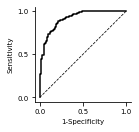

Corresponding metrics:
	Test AUROC = 0.9105708024626944


In [144]:
fig,axes = plt.subplots(1,1, figsize = (1.75,1.75))

is_filt_auc = genomic_context.plot_roc(axes, 
                                       is_all_data['test']['Y'],
                                       is_all_data['test']['Ypred'],
                                       'Test')

axes.xaxis.set_major_locator(MultipleLocator(0.5))
axes.yaxis.set_major_locator(MultipleLocator(0.5))

axes.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'is.classification_roc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(f"\tTest AUROC = {is_filt_auc}")


## Validation of site usage predictions using ENCODE RNA-seq

In [147]:
## load site data with genomic context fields

is_site_data = pd.read_csv(os.path.join(PROJECT, "model", "relative_usage", "dataset", "20220121-215928.denom.all.intron_skip_all.txt"), sep = "\t")

is_site_data['distance_downstream3ss'] = is_site_data['feature_size'] - is_site_data['distance_upstream5ss']

is_site_data['intron_pos_3'] = (is_site_data['feature_score'] == 3).astype(int)
is_site_data['up_exon_v2_log10'] = np.log10(is_site_data['distance_second_upstream3ss'] - is_site_data['distance_upstream5ss'] + 1)
is_site_data['down_exon_log10'] = np.log10(is_site_data['down_exon'] + 1)
is_site_data['feature_size_log10'] = np.log10(is_site_data['feature_size'] + 1)
is_site_data['distance_upstream5ss_log10'] = np.log10(is_site_data['distance_upstream5ss'] + 1)
is_site_data['distance_first_upstream3ss_log10'] = np.log10(is_site_data['distance_first_upstream3ss'] + 1)

is_site_data['ratio_3ss_to_3ss'] = np.log2((is_site_data['distance_downstream3ss'] + 100) / (is_site_data['distance_first_upstream3ss'] + 100))

is_site_data_scaled = pd.DataFrame(scaler_is.transform(is_site_data[is_features[1:]]), index = is_site_data.index, columns = is_site_data[is_features[1:]].columns)
is_site_data_scaled['intron_pos_3'] = is_site_data['intron_pos_3']

is_site_data['pred_prob'] = is_model.predict(is_site_data_scaled[is_features])
print(is_site_data.shape)


## filter sites with sufficient reads

is_site_pos = is_site_data.loc[is_site_data['cluster_reads_slop'] >= 10].copy()
is_site_neg = is_site_data.loc[is_site_data['cluster_reads_slop'] == 0].copy().sample(n = is_site_pos.shape[0], replace = False)

is_site_filt = pd.concat([is_site_pos, is_site_neg], sort = False, ignore_index = True)
print(is_site_filt.shape)


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(239006, 54)
(17546, 54)


Original data shape: (17546, 54)
Filtered data shape: (17475, 54)
Output results shape: (17475, 2)


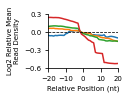

In [148]:
fig, ax = plt.subplots(1,1, figsize = (1.25,1))

distance = 20
is_a172_res = genomic_context.quantify_reads_around(is_site_filt, ENCODE_DIR, 'A172', distance = distance, subset = [('distance_upstream5ss', distance+5), ('distance_downstream3ss', distance+5)])
genomic_context.make_read_plots(ax, is_a172_res, 'skipped_intron', 'A172', distance)

ax.axhline(y = 0, color = 'black', linestyle = 'dashed', linewidth = 0.75)
ax.set_xlim((-distance,distance))
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.set_ylim(-0.6,0.3)
ax.yaxis.set_major_locator(MultipleLocator(0.3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'is.rna_validation.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## AUROC for individual predictors

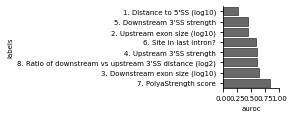

Corresponding data:
                                              labels     auroc     auprc
3                        1. Distance to 5'SS (log10)  0.266156  0.363240
5                        5. Downstream 3'SS strength  0.438753  0.463059
1                      2. Upstream exon size (log10)  0.445655  0.435613
0                            6. Site in last intron?  0.594595  0.716839
4                          4. Upstream 3'SS strength  0.604821  0.609883
7  8. Ratio of downstream vs upstream 3'SS distan...  0.613035  0.573422
2                    3. Downstream exon size (log10)  0.649297  0.647805
6                             7. PolyaStrength score  0.845128  0.848338


In [149]:
is_test_data = new_is_data.loc[new_is_data['split'] == 'test']

is_features = [
    'intron_pos_3', 
    'up_exon_v2_log10', 
    'down_exon_log10', 
    'distance_upstream5ss_log10', 
    'score_first_upstream3ss', 
    'score_downstream3ss',
    'predicted_logit', 
    'ratio_3ss_to_3ss'
]

is_labels = [is_feature_dict.get(_) for _ in is_features]
is_aurocs = []
is_auprcs = []

for icf,icl in zip(is_features, is_labels):
    auroc, auprc = genomic_context.calculate_auc(is_test_data['score_binary'], is_test_data[icf])
    is_aurocs.append(auroc)
    is_auprcs.append(auprc)
    
is_aurocs_df = pd.DataFrame.from_dict({'labels' : is_labels, 'auroc' : is_aurocs, 'auprc' : is_auprcs}, orient = 'columns')

fig,ax = plt.subplots(1,1, figsize = (1, 1.5))

sns.barplot(data = is_aurocs_df.sort_values('auroc'),
            x = 'auroc', y = 'labels', color = 'dimgray',
            edgecolor = 'black', linewidth = 0.5,
            ax = ax)

ax.set_xlim(0,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'is.individual_predictor_auroc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(is_aurocs_df.sort_values('auroc'))


## Confirmatory boxplots for model predictors

In [150]:
class_names = {0:'Not Used', 1:'Highly Used'}
class_order = ['Highly Used', 'Not Used']

is_pred = new_is_data.copy()
is_pred['pred_prob'] = is_all_data['train']['Ypred']
is_pred.loc[is_pred['split'] == 'test', 'pred_prob'] = is_all_data['test']['Ypred']

is_pred['class'] = is_pred['score_binary'].apply(lambda x : class_names[x])
is_pred['pred_prob_clip'] = np.clip(is_pred['pred_prob'], 1e-6, 1 - 1e-6)
is_pred['pred_prob_or'] = np.log2(is_pred['pred_prob_clip'] / (1 - is_pred['pred_prob_clip']))

print(is_pred.shape)


(5188, 58)


In [151]:
is_feature_dict = {
    'distance_upstream5ss_log10'       : "1. Distance to 5'SS (log10)",
    'up_exon_v2_log10'                 : '2. Upstream exon size (log10)',
    'down_exon_log10'                  : '3. Downstream exon size (log10)',
    'score_first_upstream3ss'          : "4. Upstream 3'SS strength",
    'score_downstream3ss'              : "5. Downstream 3'SS strength",
    'intron_pos_3'                     : '6. Site in last intron?',
    'predicted_logit'                  : '7. PolyaStrength score',
    'ratio_3ss_to_3ss'                 : "8. Ratio of downstream vs upstream 3'SS distance (log2)"
}


In [152]:
selected_features = ['distance_upstream5ss_log10', 'up_exon_v2_log10', 'down_exon_log10', 
                     'score_first_upstream3ss', 'score_downstream3ss', 'ratio_3ss_to_3ss']

selected_labels = [is_feature_dict.get(sf) for sf in selected_features]


#### PolyaStrength by site usage

7. PolyaStrength score:
N_Highly Used	N=2594
N_Not Used	N=2594
Baseline	WRS P-val = 0.000E+00


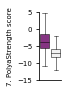

In [153]:
genomic_context.boxplot_features_outcome(OUTDIR, is_pred, 'is',
                                         ['predicted_logit'], [is_feature_dict.get("predicted_logit")],
                                         'class', class_order, ['#92278f','#f2f2f2'],
                                         figsize = (0.4,1.25), ylims_main=(-15,5), ytickint_main = 5)


#### Genomic features after controlling for PolyaStrength via quantile sampling



1. Distance to 5'SS (log10)
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


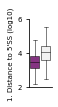

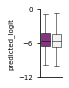

1. Distance to 5'SS (log10):
N_Highly Used	N=907
N_Not Used	N=907
Baseline	WRS P-val = 5.939E-79
predicted_logit	WRS P-val = 6.879E-01


In [163]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[0]], [selected_labels[0]], 
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['predicted_logit'],
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(2,6), ytickint_main = 2, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




2. Upstream exon size (log10)
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


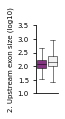

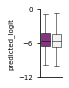

2. Upstream exon size (log10):
N_Highly Used	N=907
N_Not Used	N=907
Baseline	WRS P-val = 2.443E-09
predicted_logit	WRS P-val = 6.879E-01


In [155]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[1]], [selected_labels[1]], 
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['predicted_logit'],
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(1,3.5), ytickint_main = 0.5, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




3. Downstream exon size (log10)
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


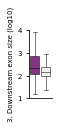

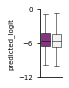

3. Downstream exon size (log10):
N_Highly Used	N=907
N_Not Used	N=907
Baseline	WRS P-val = 7.717E-22
predicted_logit	WRS P-val = 6.879E-01


In [156]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[2]], [selected_labels[2]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['predicted_logit'],
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(1,4), ytickint_main = 1, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




4. Upstream 3'SS strength
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


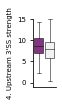

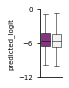

4. Upstream 3'SS strength:
N_Highly Used	N=907
N_Not Used	N=907
Baseline	WRS P-val = 1.035E-09
predicted_logit	WRS P-val = 6.879E-01


In [157]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[3]], [selected_labels[3]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['predicted_logit'],
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(-1,15), ytickint_main = 5, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




5. Downstream 3'SS strength
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


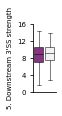

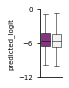

5. Downstream 3'SS strength:
N_Highly Used	N=907
N_Not Used	N=907
Baseline	WRS P-val = 2.336E-04
predicted_logit	WRS P-val = 6.879E-01


In [158]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[4]], [selected_labels[4]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['predicted_logit'],
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(0,16), ytickint_main = 4,
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




8. Ratio of downstream vs upstream 3'SS distance (log2)
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


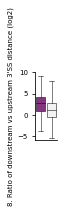

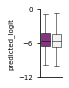

8. Ratio of downstream vs upstream 3'SS distance (log2):
N_Highly Used	N=907
N_Not Used	N=907
Baseline	WRS P-val = 1.892E-30
predicted_logit	WRS P-val = 6.879E-01


In [170]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[5]], [selected_labels[5]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['predicted_logit'],
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(-6,10), ytickint_main = 5, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




6. Site in last intron?
Defining quantiles for variable predicted_logit with 10 groups, sampling 75.0% of available sites.


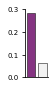

Corresponding Statistics:
statistic = 12.84692593461641
pvalue = 8.949653176776836e-38
compare = diff
method = agresti-caffo
diff = 0.21940463065049615
ratio = 4.43103448275862
odds_ratio = 5.78761273209549
variance = 0.00029038885594540834
alternative = two-sided
value = 0
tuple = (12.84692593461641, 8.949653176776836e-38)


In [160]:
is_ip3_sampled = genomic_context.quantile_sampling(is_pred, 'is', 
                                                   ['intron_pos_3'], [is_feature_dict.get('intron_pos_3')], 
                                                   'class', class_order, sample = ['predicted_logit'])

is_sum = (is_ip3_sampled
          .groupby(['class','intron_pos_3']).size()
          .reset_index().rename(columns = {0:'count'}))

is_sum['prop'] = is_sum['count'] / is_sum.groupby('class')['count'].transform('sum')

is_test = test_proportions_2indep(is_sum.loc[(is_sum['class'] == 'Highly Used') & (is_sum['intron_pos_3'] == 1), 'count'].iloc[0],
                                  is_sum.loc[(is_sum['class'] == 'Highly Used'), 'count'].sum(),
                                  is_sum.loc[(is_sum['class'] == 'Not Used') & (is_sum['intron_pos_3'] == 1), 'count'].iloc[0],
                                  is_sum.loc[(is_sum['class'] == 'Not Used'), 'count'].sum())

is_sum = is_sum.loc[is_sum['intron_pos_3'] == 1]


fig,ax = plt.subplots(1,1, figsize = (0.4, 1.25))

sns.barplot(data = is_sum, x = 'class', y = 'prop', order = class_order,
            hue = 'class', hue_order = class_order, dodge = False, palette = ['#92278f','#f2f2f2'],
            edgecolor = 'black', linewidth = 0.5)

ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0,0.3)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_xticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'is.intron_pos_3_by_usage.quantile_sampling.controlling_predicted_logit.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding Statistics:")
print(is_test)
